In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from datetime import date
import calendar

In [155]:
# importe les données dans un dataframe
birth_df0 = pd.read_csv("birth.csv", sep=",")

# Nettoyage des données

**1. Elimination des naissances dont les données liées à la date sont non renseignées**

In [156]:
print("Nombre total de lignes :", birth_df0.index.size)
print("Nombre de non nul par colonne :",birth_df0.count()) 

# Remarque : "count()" compte seulemeent les valeurs renseignées de chaque colonne contrairement à
# .size, qui compte tout

Nombre total de lignes : 15547
Nombre de non nul par colonne : year      15547
month     15547
day       15067
gender    15547
births    15547
dtype: int64


En comptant les éléments par colonne on s'aperçoit que seuls certains jours ne sont pas renseignés.

Il faut éliminer les lignes correspondantes :

In [162]:
print("Nbe de lignes, avant nettoyage :" , birth_df0.index.size)

# élimination des lignes dont l'année, le mois ou le jour n'est pas renseigné
birth_df1 = birth_df0.dropna(subset = ['year','month','day'], inplace=False)

#index des lignes éliminées
temp = list(set(birth_df0.index) - set(birth_df1.index))

# nbe de lignes après triage
print("Nbe de lignes, après nettoyage :", birth_df1.index.size)
print("Nbe de lignes éliminées :", len(temp))

Nbe de lignes, avant nettoyage : 15547
Nbe de lignes, après nettoyage : 15067
différence : 480


,year,month,day,gender,births
15546,2008,12,NaN,M,181235


In [129]:
# on garde seulement les lignes dont les jours sont compris entre 1 et 31
cond_d = pd.Series([birth_df.day.values[i] in range (1,32) for i in range(len(birth_df.day))], \
                   index = birth_df.day.index)

birth_df = birth_df.where(cond_d).dropna()

In [130]:
# Crée une dataframe contenant les données pour former les dates

date_df = pd.DataFrame({'year':birth_df.year.values.astype(int),\
                        'month':birth_df.month.values.astype(int),\
                        'day':birth_df.day.values.astype(int)})
date_ser = pd.to_datetime(date_df,errors='coerce') # type "Series"

birth_df["date"] = date_ser
birth_df.drop(columns = ["month", "day"], inplace=True)

In [131]:
# élimination des lignes dont l'année, le mois et le jour forment une date qui n'existe pas
# notamment les 29 janvier d'années non bissextile
birth_df = birth_df.dropna(subset = ['date'])

# nbe de lignes après triage
print("Nbe de lignes, après nettoyage :", birth_df.index.size)

birth_df.head(5)

Nbe de lignes, après nettoyage : 14610


,year,gender,births,date
0,1969,F,4046,1969-01-01
1,1969,M,4440,1969-01-01
2,1969,F,4454,1969-01-02
3,1969,M,4548,1969-01-02
4,1969,F,4548,1969-01-03


In [132]:
# ajout d'une nouvelle colonne indiquant le nom du jour de naissance

tab = [calendar.day_name[birth_df.iloc[i].date.weekday()] for i in range(birth_df.index.size)]

day_week_ser = pd.Series(tab)
birth_df["day_week"] = day_week_ser

In [133]:
# nbe de lignes après triage
print("Nbe de lignes, après nettoyage :", birth_df.index.size)
birth_df.head(3)

Nbe de lignes, après nettoyage : 14610


,year,gender,births,date,day_week
0,1969,F,4046,1969-01-01,Wednesday
1,1969,M,4440,1969-01-01,Wednesday
2,1969,F,4454,1969-01-02,Thursday


In [134]:
masque = pd.cut(birth_df['year'], np.array([1960,1970,1980,1990]))
birth_pt = birth_df.pivot_table('births', index = [masque], columns = 'day_week', aggfunc = "sum")

In [135]:
birth_pt

day_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
year,,,,,,,
"(1960, 1970]",1070836,1038428,1051488,1047386,1066176,1022008,1036862
"(1970, 1980]",4739125,4728135,4753032,4757000,4730230,4790776,4764177
"(1980, 1990]",3947525,3894223,3948901,3882342,3924497,3914391,3899623


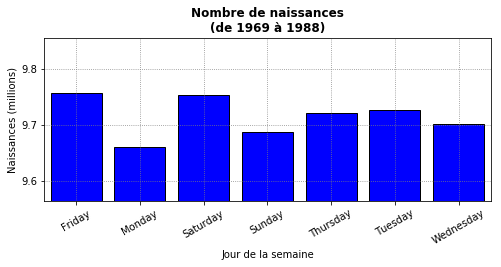

In [136]:
y_60 = birth_pt.iloc[0].values
y_70 = birth_pt.iloc[1].values
y_80 = birth_pt.iloc[2].values
y = y_60 + y_70 + y_80
ind = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
#ind = birth_pt.iloc[0].index

y_min = np.min(y)*0.99/1e6
y_max = np.max(y)*1.01/1e6

fig = plt.figure(figsize=(8,3))

plt.bar(range(len(y)),y/1000000,edgecolor='k', color='blue', label='naissances')

plt.title("Nombre de naissances\n(de 1969 à 1988)",fontweight="bold")
plt.xlabel("Jour de la semaine")
plt.ylabel("Naissances (millions)")
plt.axis([-0.5, 6.5, y_min, y_max])
plt.rcParams.update({'font.size': 15})
plt.grid(color='grey', linestyle='dotted')
plt.xticks(range(7), ind, rotation=30)
#plt.legend(loc='upper right')

plt.show()



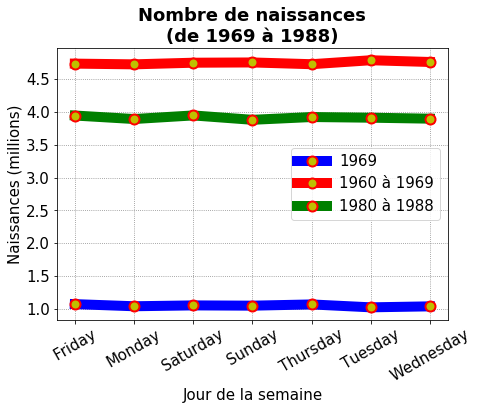

In [137]:
## Nombre de naissance pour chaque jour de la semaine pour les décénnies 60, 70 et 80

fig = plt.figure(figsize=(7,5))

plt.plot(range(len(y_60)),(y_60)/1000000, \
         'o', c='blue', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2, \
         label='1969',zorder = 5)
plt.plot(range(len(y_70)),(y_70)/1000000, \
         'o', c='red', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2, \
         label='1960 à 1969',zorder = 10)
plt.plot(range(len(y_80)),(y_80)/1000000, \
         'o', c='green', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2, \
         label='1980 à 1988',zorder = 15)

plt.title("Nombre de naissances\n(de 1969 à 1988)",fontweight="bold")
plt.xlabel("Jour de la semaine")
plt.ylabel("Naissances (millions)")
plt.rcParams.update({'font.size': 15})
plt.grid(color='grey', linestyle='dotted')
plt.xticks(range(7), ind, rotation=30)
plt.legend(loc='best')

plt.show()

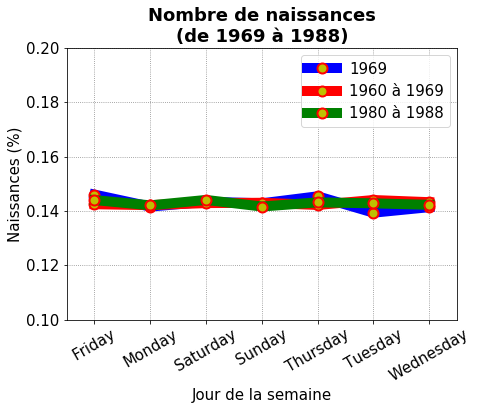

In [138]:
## Pourcentage des naissances pour chaque jour
# étiquettes de la valeur pour chaque barre


fig = plt.figure(figsize=(7,5))

plt.plot(range(len(y_60)),(y_60/np.sum(y_60)), \
         'o', c='blue', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2, \
         label='1969',zorder = 5)
plt.plot(range(len(y_70)),(y_70/np.sum(y_70)), \
         'o', c='red', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2, \
         label='1960 à 1969',zorder = 10)
plt.plot(range(len(y_80)),(y_80/np.sum(y_80)), \
         'o', c='green', lw=10, ls='solid', \
         ms = 10, mfc = 'y', mec='red',  mew = 2, \
         label='1980 à 1988',zorder = 15)

plt.title("Nombre de naissances\n(de 1969 à 1988)",fontweight="bold")
plt.xlabel("Jour de la semaine")
plt.ylabel("Naissances (%)")
plt.rcParams.update({'font.size': 15})
plt.axis([-0.5, 6.5, 0.1, 0.2])
plt.grid(color='grey', linestyle='dotted')
plt.xticks(range(7), ind, rotation=30)
plt.legend(loc='best')

plt.show()

In [139]:
mettre dans l'ordre les index et en français
mise en forme graphe

SyntaxError: invalid syntax (<ipython-input-139-88367ac4018f>, line 1)

In [118]:
print(np.array(range(1,32)))
print(np.array(range(birth_df.index.size)))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
[    0     1     2 ... 14607 14608 14609]
